<a href="https://colab.research.google.com/github/lorenzosintini/4YP/blob/master/CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import random
import time
import os
import sys
from IPython.display import clear_output
import os
tf.autograph.set_verbosity(0)
tf.executing_eagerly()

TensorFlow 2.x selected.


True

11493376/11490434 [==============================] - 0s 0us/step


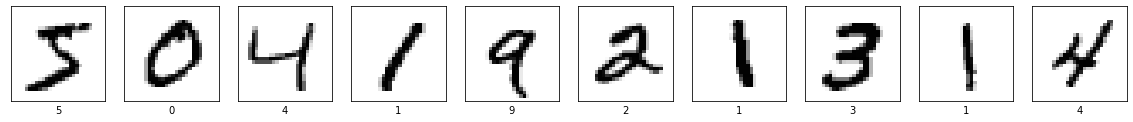

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

class_names = ['Zero','One', 'Two', 'Three', 'Four', 'Five','Six', 'Seven', 'Eight', 'Nine']
N_image_channels = 1
N_class = len(class_names)
image_shape = x_train.shape[1:3]
input_range = np.amax(x_train)

def plot_images(x_train, y_train, figures_to_plot, pick_random=False, include_labels=True):
    n_rows = np.ceil((figures_to_plot[1])/10)
    plot = plt.figure(figsize=[20,2*n_rows])
    for i in range(figures_to_plot[0],figures_to_plot[1]):
        if pick_random: 
            pic_n = random.randint(0,len(x_train))
        else: pic_n = i
        plt.subplot(n_rows,10,i+1)
        plt.xticks([]); plt.yticks([])
        plt.imshow(x_train[pic_n], cmap=plt.cm.binary)
        if include_labels:
            plt.xlabel(y_train[pic_n])
    plt.show()

plot_images(x_train, y_train, [0,10])

In [0]:
def pick_class(x, y, class_n):
    pics = (y == class_n[0])
    for i in range(len(class_n)-1):
      pics = pics + (y == class_n[i+1])
    new_x = x[pics]
    new_y = y[pics]
    return new_x, new_y

def set_pixels_binary(images):
    images = images/input_range
    images[images >= 0.5] = 1.0
    images[images < 0.5] = 0.0
    return images

def make_categorical(y, n):
    y_cat = tf.keras.utils.to_categorical(y, num_classes=n)
    return y_cat

def resort_classes(y):
    new_y = np.zeros(np.shape(y))
    classes = np.unique(y)
    for i in range(len(y)):
        for j in range(len(classes)):
            if y[i]==classes[j]:
                new_y[i]=j
    return new_y

def cut_data(data, data_number):
    data = data[0:data_number]
    return data

def setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=[0,1,2,3,4,5,6,7,8,9], data_number = -1):
    x_train, y_train = pick_class(x_train, y_train, chosen_classes)
    x_test, y_test = pick_class(x_test, y_test, chosen_classes)
  
    x_train = cut_data(x_train, data_number)
    y_train = cut_data(y_train, data_number)

    train_images = set_pixels_binary(x_train)
    test_images = set_pixels_binary(x_test)

    train_images = train_images.reshape(len(y_train), image_shape[0], image_shape[1], N_image_channels).astype('float32')
    test_images = test_images.reshape(len(y_test), image_shape[0], image_shape[1], N_image_channels).astype('float32')

    reclassed_y_train = resort_classes(y_train)
    reclassed_y_test = resort_classes(y_test)

    train_labels = make_categorical(reclassed_y_train, len(chosen_classes))
    test_labels = make_categorical(reclassed_y_test, len(chosen_classes))

    batch_size = 100
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(len(y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).shuffle(len(y_test)).batch(batch_size)
    
    return x_train, y_train, x_test, y_test, train_dataset, test_dataset

In [0]:
class CVAE(tf.keras.Model):
    def __init__(self, z_size):
        super(CVAE, self).__init__()
        self.z_size = z_size
        self.enc1 = tf.keras.layers.Flatten(input_shape=(28, 28, 1))
        self.enc2 = tf.keras.layers.concatenate
        self.enc3 = tf.keras.layers.Dense(512, activation='relu')
        self.enc4 = tf.keras.layers.Dense(z_size*2)

        self.dec1 = tf.keras.layers.concatenate
        self.dec2 = tf.keras.layers.Dense(units=512, activation='relu', input_shape=(z_size+n_classes,))
        self.dec3 = tf.keras.layers.Dense(784)
        self.dec4 = tf.keras.layers.Reshape(target_shape=(28, 28, 1))

    def encode(self, x, y):
        x = self.enc1(x)
        x = self.enc2([x, y], axis=1)
        x = self.enc3(x)
        x = self.enc4(x)
        encoder_nn_output = x
        z_mean, z_logvar = tf.split(encoder_nn_output, num_or_size_splits=2, axis=1)
        return z_mean, z_logvar

    def reparameterize(self, z_mean, z_logvar):
        epsilon = tf.random.normal(shape=z_mean.shape)
        z_sampled = epsilon * tf.exp(z_logvar * 0.5) + z_mean
        return z_sampled   

    def decode(self, z, y):
        z = self.dec1([z, y], axis=1)
        z = self.dec2(z)
        z = self.dec3(z)
        z = self.dec4(z)
        pixel_output = z
        pixel_prob = tf.math.sigmoid(pixel_output)
        return pixel_prob

In [0]:
def calculate_ELBO(model, x, y):
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    
    pixel_prob = model.decode(z, y)
    
    logpx_z_pixels = tf.math.log(pixel_prob + 1e-10)*x + tf.math.log(1-pixel_prob + 1e-10)*(1-x)
    logpx_z_images = tf.reduce_sum(logpx_z_pixels, axis=[1, 2, 3])
    logpx_z = tf.reduce_mean (logpx_z_images)
    
    KL_parameters = -0.5 * (1 + z_logvar - (z_mean ** 2.0) - tf.exp(z_logvar))
    KL_vectors = tf.reduce_sum(KL_parameters, axis=1)
    KL = tf.reduce_mean(KL_vectors)
    
    ELBO = (logpx_z - KL)
    
    return -ELBO #Negative because we want to maximise it

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
train_loss = tf.keras.metrics.Mean(name='train_loss')
test_loss = tf.keras.metrics.Mean(name='test_loss')

In [0]:
def train_step(model, x, y, optimizer):
    with tf.GradientTape() as tape:
        loss = calculate_ELBO(model, x, y)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)

def test_step(model, x, y, optimizer):
    loss = calculate_ELBO(model, x, y)
    test_loss(loss)

In [0]:
def generate_images(model, z_random, y, figures_to_plot):
    generated_prob = model.decode(z_random, y)
    generated_prob = np.squeeze(generated_prob, axis=3)
    plot_images(generated_prob, _, figures_to_plot, include_labels=False)

In [0]:
def train_test_dataset(model, train_dataset, test_dataset, epochs, generate=True):
  plots_per_epoch = n_classes
  z_random = tf.random.normal(shape=[plots_per_epoch, z_size])
  y_generate = np.eye(n_classes)

  test_ELBO = []
  train_ELBO = []
  epoch_number = []
  for epoch in range(epochs):
    print('Epoch {}'.format(epoch))
    for train_x, train_y in train_dataset: 
      train_step(model, train_x, train_y, optimizer)
  
    for test_x, test_y in test_dataset:
      test_step(model, test_x, test_y, optimizer)
    
    test_ELBO.append(-test_loss.result())
    train_ELBO.append(-train_loss.result())
    epoch_number.append(epoch)
    
    clear_output()
    if generate:
      generate_images(model, z_random, y_generate, [0,plots_per_epoch])
    plt.plot(epoch_number, test_ELBO, train_ELBO)
    plt.legend(['test','train'])
    plt.title('model')
    plt.show()
  train_loss.reset_states()
  test_loss.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



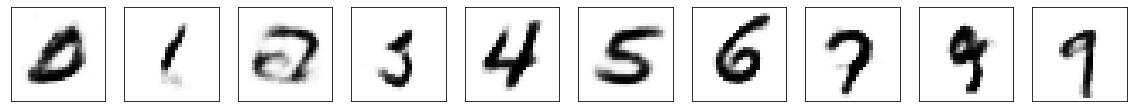

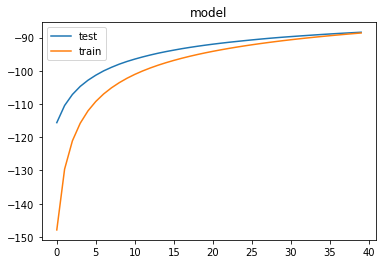

Remember that the classes represent the following original classes:
class:0 is 0
class:1 is 1
class:2 is 2
class:3 is 3
class:4 is 4
class:5 is 5
class:6 is 6
class:7 is 7
class:8 is 8
class:9 is 9


In [10]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

chosen_classes=[0,1,2,3,4,5,6,7,8,9]
n_classes = len(chosen_classes)
x_train, y_train, x_test, y_test, train_dataset, test_dataset = setup_dataset(x_train, y_train, x_test, y_test, chosen_classes=chosen_classes, data_number=-1)
reclassed_y_train = resort_classes(y_train)
reclassed_y_test = resort_classes(y_test)
train_labels = make_categorical(reclassed_y_train, n_classes)
test_labels = make_categorical(reclassed_y_test, n_classes)

z_size = 10
model = CVAE(z_size)
train_test_dataset(model, train_dataset, test_dataset, 40, generate=True)

print('Remember that the classes represent the following original classes:')
classes = np.unique(y_train)
for i in range(len(classes)):
    print('class:{} is {}'.format(i,classes[i]))

#### Reconstruct images

Original Pictures:


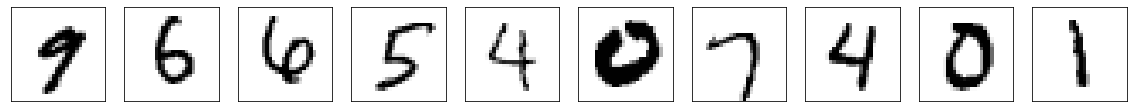

Reconstructed Pictures, with ELBO loss:


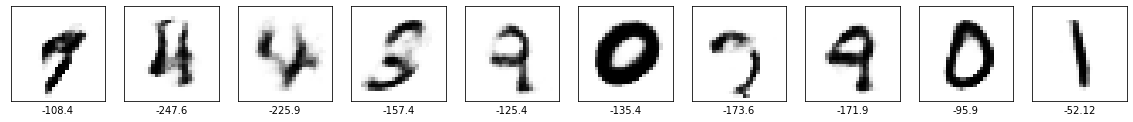

In [17]:
def reconstruct_images(model, images, labels):
    images_n = len(images)
    x = images/255
    x[x >= 0.5] = 1.0
    x[x < 0.5] = 0.0
    x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    reclassed_labels = resort_classes(labels)
    y = make_categorical(reclassed_labels, n_classes)
    
    z_mean, z_logvar = model.encode(x, y)
    z = model.reparameterize(z_mean, z_logvar)
    pixel_output = model.decode(z, y)
    pixel_prob = tf.math.sigmoid(pixel_output)
    pixel_prob = np.squeeze(pixel_prob, axis=3)

    loss = np.empty([images_n])
    for i in range(images_n):
        loss[i] = calculate_ELBO(model,x[i:i+1], y[i:i+1])
    loss = loss.astype('float16')
    
    print('Original Pictures:')
    plot_images(images, _, figures_to_plot=[0,images_n], include_labels=False)
    print('Reconstructed Pictures, with ELBO loss:')
    plot_images(pixel_prob, -loss, figures_to_plot=[0,images_n], include_labels=True)

reconstruct_images(model, x_test[20:30], y_test[20:30])

#### Visualise latent space

0 Outliers detected


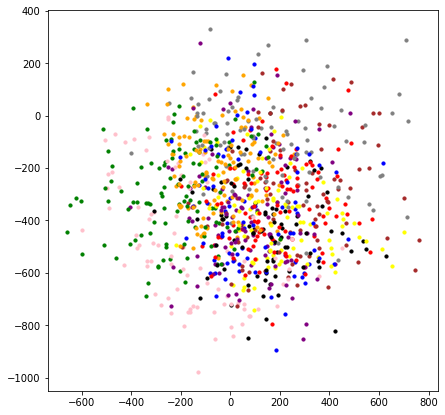

In [12]:
def visualize_latent_space(model, range1, range2, data_x, data_y, a, b):
  plot = plt.figure(figsize=[7,7])
  outliers=0
  for i in range(range1, range2):
    pic_visualize = data_x[i]
    pic_visualize = pic_visualize.reshape(1, image_shape[0], image_shape[1], N_image_channels).astype('float32')
    label_visualize = data_y[i]
    label_visualize = label_visualize.reshape(1, len(label_visualize))
    
    z_mean, z_logvar = model.encode(pic_visualize, label_visualize)
    z = model.reparameterize(z_mean, z_logvar)
    num=np.argmax(label_visualize)

    if num == 0:
      color = 'blue'
    if num == 1:
      color = 'orange'
    if num == 2:
      color = 'green'
    if num == 3:
      color = 'red'
    if num == 4:
      color = 'purple'  
    if num == 5:
      color = 'brown'
    if num == 6:
      color = 'pink'
    if num == 7:
      color = 'gray'
    if num == 8:
      color = 'black'
    if num == 9:
      color = 'yellow'
    plt.scatter(z[:,a],z[:,b], color=color, s=10)
  print('{} Outliers detected'.format(outliers))

visualize_latent_space(model, 0,1000, x_test, test_labels, 0,1)

#### Generate numbers


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



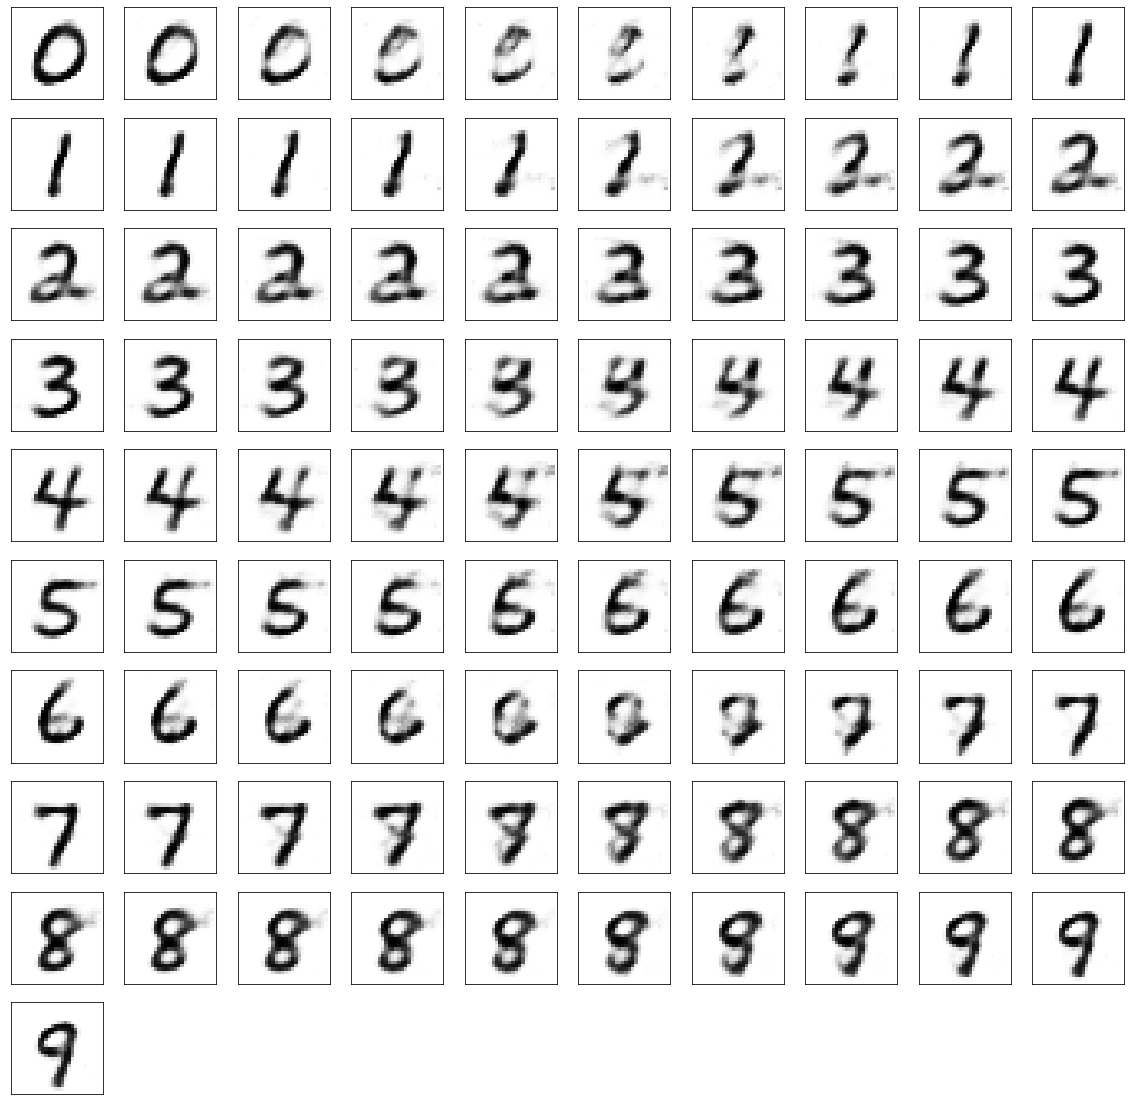

In [18]:
z_random = tf.random.normal(shape=[1, z_size])
manual_z = np.ones([1,z_size])*0
rows = ((n_classes)-1)*10
y_generate = np.zeros((rows+1, n_classes+z_size))
for i in range(rows):
  m = i // 10
  r = i % 10
  y_generate[i, m+z_size] = 1 - r*0.1
  y_generate[i, m + z_size+1]= r *0.1
y_generate[-1,-1]=1
y_generate[:,:z_size] = manual_z
generate_images(model, y_generate[:,:z_size], y_generate[:,z_size:], [0,rows+1])

#### Classify test images

In [19]:
images = x_test
predicted_class = np.zeros([1,len(images)])
images_n = len(images)
x = images/255
x[x >= 0.5] = 1.0
x[x < 0.5] = 0.0
x = x.reshape(images_n, image_shape[0], image_shape[1], N_image_channels).astype('float32')
loss = np.empty([images_n, n_classes])

for j in range(n_classes):
  print('Ran class {}'.format(j))
  ytest = np.ones([len(images),])*j
  y = make_categorical(ytest, n_classes)
  for i in range(images_n):
      loss[i,j] = calculate_ELBO(model,x[i:i+1], y[i:i+1])

for i in range(images_n):
  predicted_class[0,i] = np.argmin(loss[i,:])
print(predicted_class)

Ran class 0
Ran class 1
Ran class 2
Ran class 3
Ran class 4
Ran class 5
Ran class 6
Ran class 7
Ran class 8
Ran class 9
[[7. 2. 1. ... 4. 5. 6.]]


Correctly labelled pictures:9688/10000 -> Accuracy: 96.88%
Incorrectly labelled pictures:312/10000 -> Error: 3.1200000000000006%


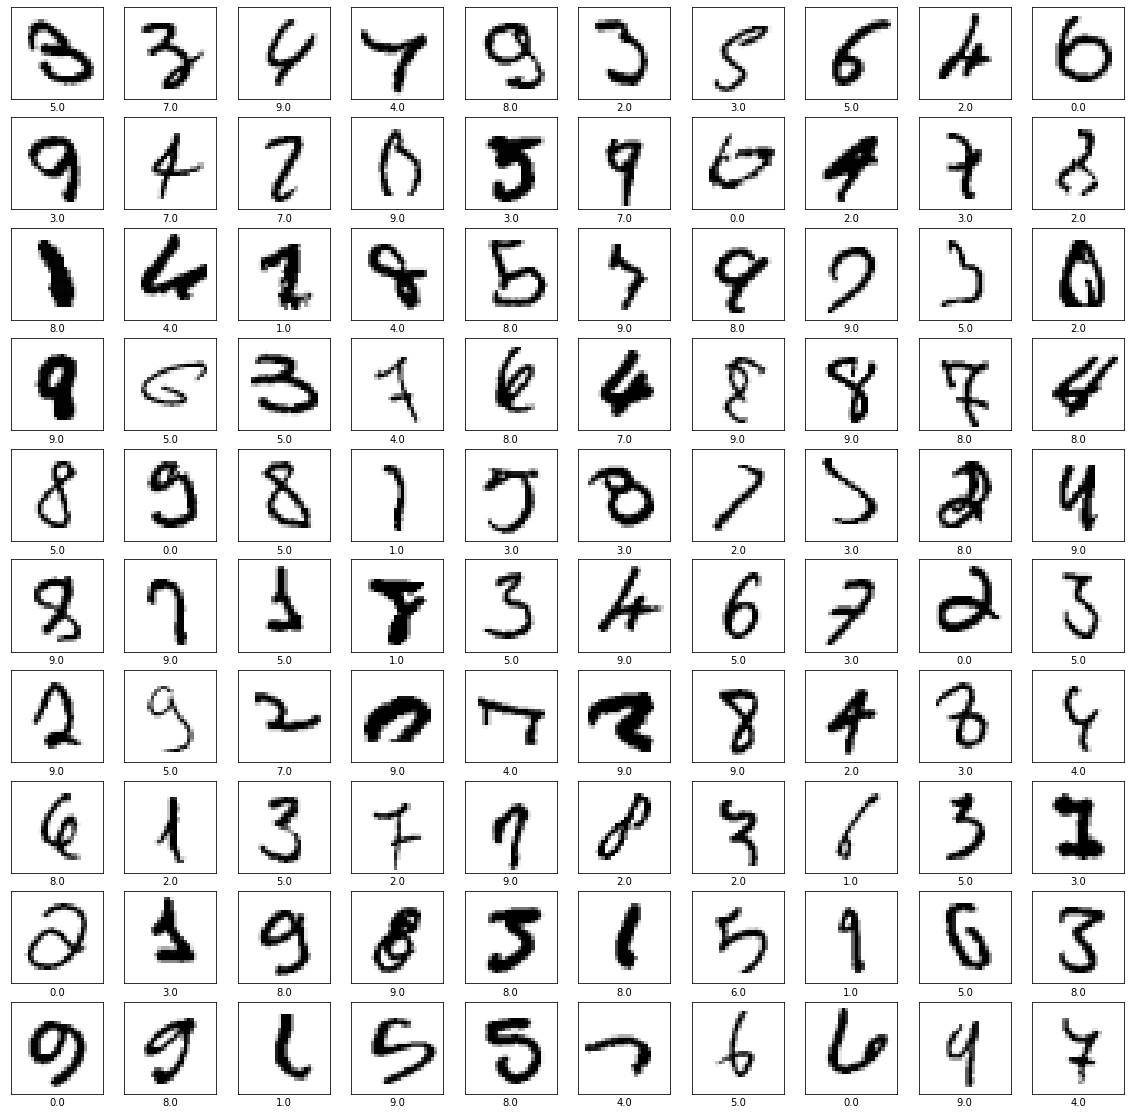

In [20]:
correct_guesses = 0
wrong_guesses = []
reclassed_y_test = resort_classes(y_test)
for i,x in enumerate(zip(predicted_class[0,:], reclassed_y_test)):
    if (x[0]==x[1]):
        correct_guesses = correct_guesses + 1
    else:
        wrong_guesses.append(i)
    total_guesses = len(reclassed_y_test)
    accuracy = (correct_guesses/total_guesses)
print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(correct_guesses,total_guesses,accuracy*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(total_guesses-correct_guesses,total_guesses,(1-accuracy)*100))


pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
plot_images(pics_to_plot[0:100], labels[0:100], [0,len(labels[0:100])])


In [0]:
# Conditional VAE for each class results in accuracy of 92.93% with z_size = 2
# Conditional VAE for each class results in accuracy of 96.83% with z_size = 10

Correctly labelled pictures:9688/10000 -> Accuracy: 96.88%
Incorrectly labelled pictures:312/10000 -> Error: 3.1199999999999997%


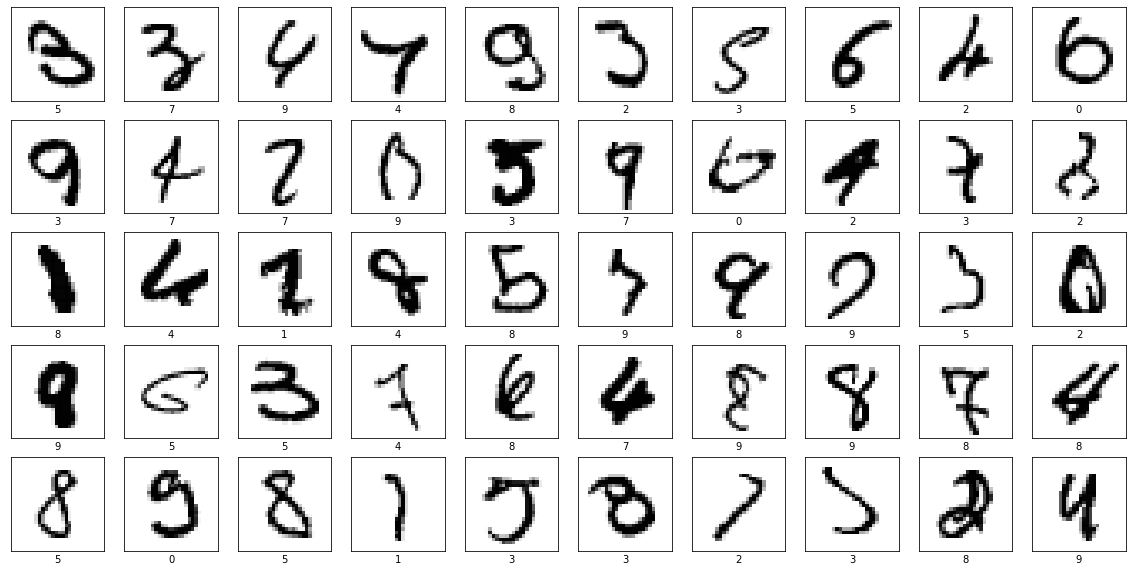

,|0_Counts|,|1_Counts|,|2_Counts|,|3_Counts|,|4_Counts|,|5_Counts|,|6_Counts|,|7_Counts|,|8_Counts|,|9_Counts|,Percentage
Class 0,968.0,0.0,2.0,0.0,0.0,0.0,4.0,1.0,1.0,4.0,98.775510
Class 1,1.0,1118.0,4.0,2.0,0.0,1.0,1.0,1.0,7.0,0.0,98.502203
Class 2,3.0,4.0,999.0,5.0,1.0,0.0,1.0,7.0,5.0,7.0,96.802326
Class 3,1.0,0.0,7.0,972.0,1.0,16.0,0.0,1.0,12.0,0.0,96.237624
Class 4,0.0,1.0,7.0,0.0,958.0,0.0,1.0,6.0,3.0,6.0,97.556008
Class 5,1.0,0.0,0.0,10.0,0.0,863.0,5.0,1.0,10.0,2.0,96.748879
Class 6,5.0,2.0,1.0,2.0,4.0,14.0,926.0,0.0,3.0,1.0,96.659708
Class 7,2.0,3.0,8.0,5.0,16.0,0.0,0.0,983.0,2.0,9.0,95.622568
Class 8,1.0,1.0,4.0,5.0,4.0,5.0,2.0,2.0,943.0,7.0,96.817248
Class 9,3.0,2.0,3.0,6.0,14.0,5.0,0.0,10.0,8.0,958.0,94.945491


In [27]:
import pandas as pd
predicted_class = predicted_class.astype('int')
reclassed_y_test = reclassed_y_test.astype('int')

wrong_guesses = []
table_of_counts = np.zeros([n_classes, n_classes+1])
for i in range(predicted_class.shape[1]):
    table_of_counts[reclassed_y_test[i], predicted_class[0,i]]+=1
    if reclassed_y_test[i] != predicted_class[0,i]:
        wrong_guesses.append(i)
trace_count = table_of_counts.trace().astype('int')
sum_count = table_of_counts.sum().astype('int')
for i in range(n_classes):
    table_of_counts[i,-1] = 100*table_of_counts[i,i]/np.sum(table_of_counts[i,0:-1])

index = list(str('-') * n_classes)
columns = list(str('-') * (n_classes+1))
for i in range(n_classes):
    index[i]= 'Class '+ str(i)
    columns[i] = '|' + str(i) + '_Counts|'
columns[-1] = 'Percentage'
table = pd.DataFrame.from_records(table_of_counts, index=index, columns=columns)

print('Correctly labelled pictures:{}/{} -> Accuracy: {}%'.format(trace_count, sum_count, trace_count/sum_count*100))
print('Incorrectly labelled pictures:{}/{} -> Error: {}%'.format(sum_count-trace_count, sum_count, (sum_count-trace_count)/sum_count*100))

pics_to_plot = list(x_test[i] for i in wrong_guesses)
labels = list(predicted_class[0,i] for i in wrong_guesses)
plot_images(pics_to_plot[0:50], labels[0:50], [0,len(labels[0:50])])

table